In [1]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.metrics import *
from keras.optimizers import *
from keras.applications import *
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random

from flask import Flask, render_template, request
import os

In [6]:


trainDataset = ['../deployment/DATA/Training/']
testDataset = ['../deployment/DATA/Testing/']

trainPaths = []
trainLables = []

for trainDir in trainDataset:
    for label in os.listdir(trainDir):
        for image in os.listdir(trainDir+label):
            trainPaths.append(trainDir+label+'/'+image)
            trainLables.append(label)

trainPaths, trainLables = shuffle(trainPaths, trainLables)

testPaths = []
testLables = []

for testDir in testDataset:
    for label in os.listdir(testDir):
        for image in os.listdir(testDir+label):
            testPaths.append(testDir+label+'/'+image)
            testLables.append(label)

testPaths, testLables = shuffle(testPaths, testLables)
uniqueLables = os.listdir(trainDir)



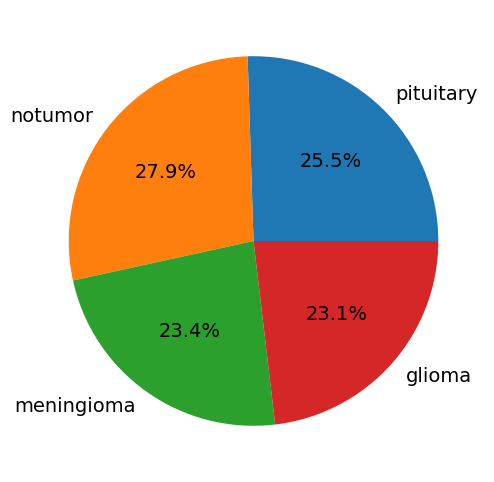

In [7]:
plt.figure(figsize=(14,6))
plt.rcParams.update({'font.size': 14})
plt.pie(
    [
        len([x for x in trainLables if x == 'pituitary']),
        len([x for x in trainLables if x == 'notumor']),
        len([x for x in trainLables if x == 'meningioma']),
        len([x for x in trainLables if x == 'glioma'])
    ],
    labels=['pituitary','notumor', 'meningioma', 'glioma'],
    autopct='%.1f%%'
);

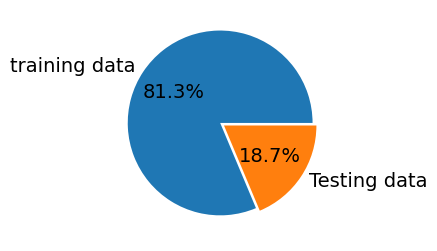

In [9]:
plt.figure(figsize=(3,3))
plt.pie(
    [len(trainLables), len(testLables)],
    labels=['training data','Testing data'],
    autopct='%.1f%%', explode=(0.05,0),
);

In [10]:
agu = 0.5
def augmentImages(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(1-agu,1+agu))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(1-agu,1+agu))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(1-agu,1+agu))
    
    image = np.array(image)/255.0
    return image
    

In [13]:
from PIL import Image, ImageFilter
import PIL
import matplotlib.pyplot as plt

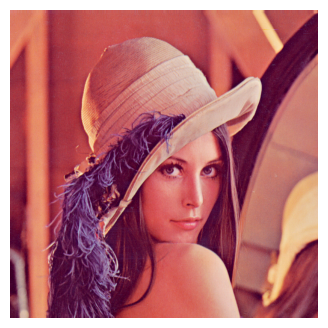

In [34]:
im = PIL.Image.open('../lenna.png')


im = ImageEnhance.Brightness(im).enhance(random.uniform(1-agu,1+agu))
im = ImageEnhance.Contrast(im).enhance(random.uniform(1-agu,1+agu))
im = ImageEnhance.Sharpness(im).enhance(random.uniform(1-agu,1+agu))

fg = plt.figure(figsize=(4,4))
fg.add_subplot(111)
plt.axis("off")
plt.imshow(im)
plt.show()


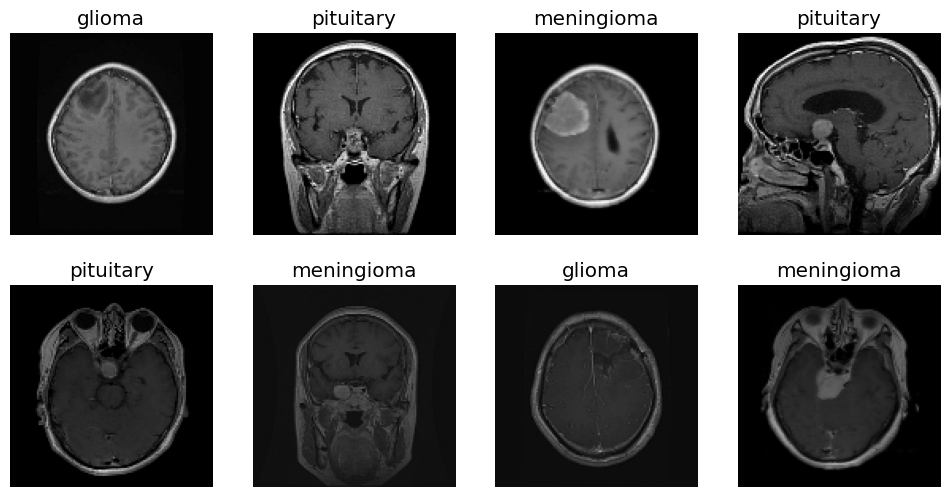

In [19]:
imageSize = 128

def openImages(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(imageSize,imageSize))
        image = augmentImages(image)
        images.append(image)
    return np.array(images)


images = openImages(trainPaths[40:49])
lbl = trainLables[40:49]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(lbl[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [20]:
uniqueLables = os.listdir(trainDir)

def encodeLables(labels):
    encoded = []
    for x in labels:
        encoded.append(uniqueLables.index(x))
    return np.array(encoded)

def decodeLables(labels):
    decoded = []
    for x in labels:
        decoded.append(uniqueLables[x])
    return np.array(decoded)


def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = openImages(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encodeLables(batch_labels)
            yield batch_images, batch_labels

In [21]:
import tensorflow as tf

In [23]:
model = tf.keras.models.load_model('../model.keras')

In [24]:
baseModel = VGG16(input_shape=(imageSize,imageSize,3), include_top=False, weights='imagenet')
for layer in baseModel.layers:
    layer.trainable = False
# Set the last vgg block to trainable
baseModel.layers[-2].trainable = True
baseModel.layers[-3].trainable = True
baseModel.layers[-4].trainable = True


model = Sequential()
model.add(Input(shape=(imageSize,imageSize,3)))
model.add(baseModel)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(uniqueLables), activation='softmax'))


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batchSize = 25
steps = int(len(trainPaths)/batchSize)
epochs = 1
history = model.fit(datagen(trainPaths, trainLables, batchSize=batchSize, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


In [27]:
model.save("model.keras")
print("MAKE SURE ITS IN THE RIGHT PLACE")


MAKE SURE ITS IN THE RIGHT PLACE


In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
steps = int(len(testPaths)/batchSize)
yPred = []
yTrue = []
for x,y in tqdm(datagen(testPaths, testLables, batchSize=batchSize, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decodeLables(pred):
        yPred.append(i)
    for i in decodeLables(y):
        yTrue.append(i)

In [ ]:
print(classification_report(yTrue, yPred))

1/1 [==============================] - 0s 78ms/step


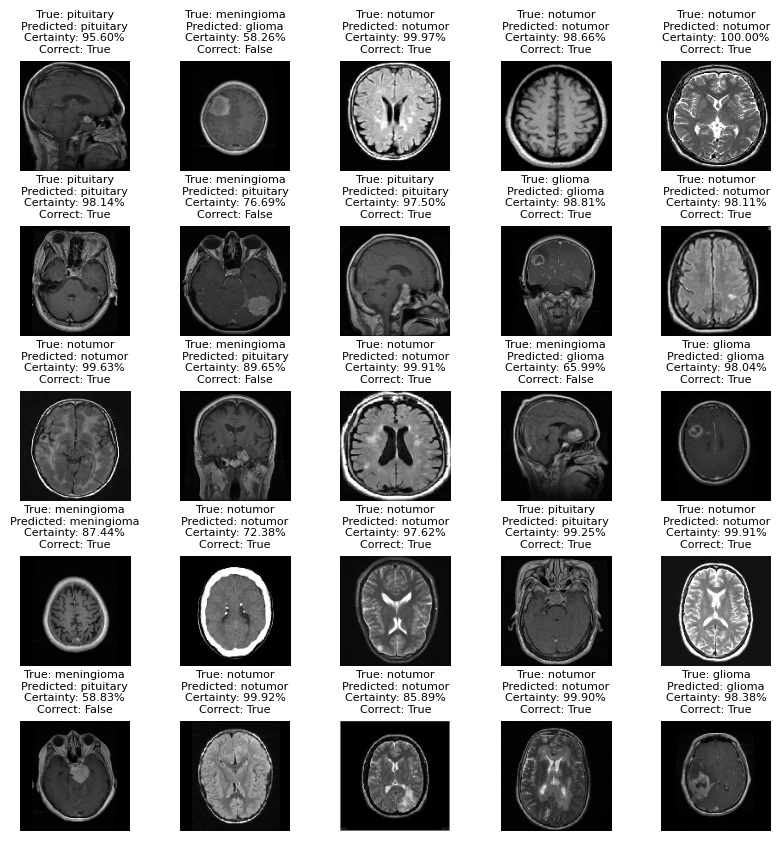

In [25]:
# Demonstration of a 10 by 10 grid with predictions and certainty

# Function to get predictions and probabilities
def predictAndPlot(model, paths, labels, n_samples=100):
    plt.figure(figsize=(10, 10))
    for i in range(min(n_samples, len(paths))):
        index = random.randint(0, len(paths)-1)
        image_path = paths[index]
        true_label = labels[index]
        
        image = load_img(image_path, target_size=(imageSize, imageSize))
        image_array = np.array([augmentImages(image)])
        plt.subplots_adjust(hspace=0.5)

        prediction_probabilities = model.predict(image_array)[0];
        predicted_label_index = np.argmax(prediction_probabilities);
        predicted_label = uniqueLables[predicted_label_index];
        certainty = prediction_probabilities[predicted_label_index] * 100;
        correct = true_label == predicted_label;
        
        plt.subplot(5, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nCertainty: {certainty:.2f}%\nCorrect: {correct}', fontsize=8)

# Call the function to plot the demonstration
predictAndPlot(model, testPaths, testLables, n_samples=25);
plt.show()


In [26]:
import tensorflow as tf

38/38 [==============================] - 39s 1s/step


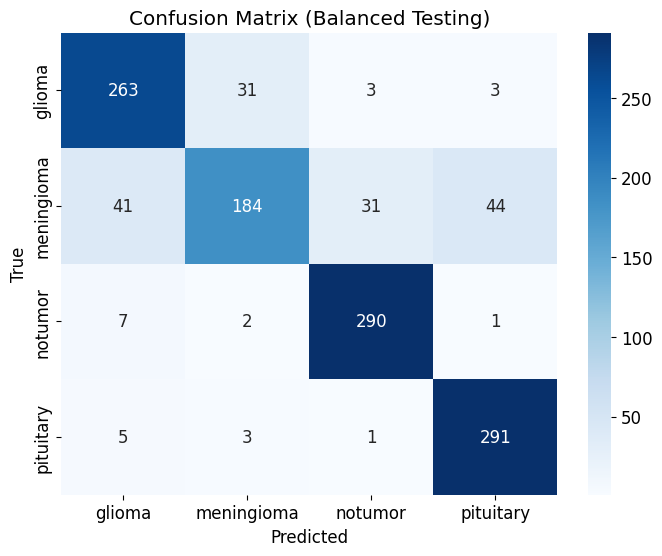

In [30]:
min_samples_per_class = min([testLables.count(label) for label in uniqueLables])
balanced_testPaths = []
balanced_testLables = []

for label in uniqueLables:
    class_paths = [path for path, lbl in zip(testPaths, testLables) if lbl == label]
    balanced_testPaths.extend(class_paths[:min_samples_per_class])
    balanced_testLables.extend([label] * min_samples_per_class)


test_images_balanced = openImages(balanced_testPaths)
testLables_encoded_balanced = encodeLables(balanced_testLables)

predictions_balanced = model.predict(test_images_balanced)
predicted_labels_balanced = np.argmax(predictions_balanced, axis=1)

confusion_matrix_balanced = tf.math.confusion_matrix(testLables_encoded_balanced, predicted_labels_balanced, num_classes=len(uniqueLables))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=uniqueLables, yticklabels=uniqueLables)
plt.title('Confusion Matrix (Balanced Testing)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


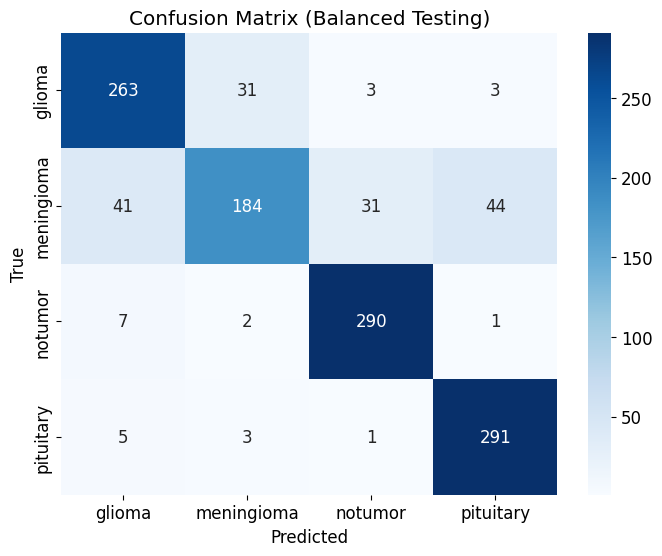

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=uniqueLables, yticklabels=uniqueLables)
plt.title('Confusion Matrix (Balanced Testing)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [33]:
# Calculate Accuracy for Balanced Testing

accuracy_balanced = np.sum(np.diag(confusion_matrix_balanced)) / np.sum(confusion_matrix_balanced)
print(f"Accuracy on Balanced Testing (100 samples): {accuracy_balanced:.2%}")


Accuracy on Balanced Testing (100 samples): 85.67%


In [2]:
# def prd(imagePath):
#     img = tf.keras.preprocessing.image.load_img(imagePath, target_size=(28, 28), color_mode='grayscale')
#     imgArray = tf.keras.preprocessing.image.img_to_array(img)
#     imgArray = tf.expand_dims(imgArray, 0)  # Create batch axis
#     immArray = imgArray / 255.0  # Normalize pixel values

#     predictions = model.predict(imgArray)
    

#     return predictions

def prd(imagePath):
    return("80")

In [9]:
from flask import Flask, render_template, request
import os

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def uploadFile():
    if request.method == 'POST':
        uploadedFile = request.files['file']
        if uploadedFile:
            tempDir = os.path.join(os.path.dirname(__file__), 'temp')
            if not os.path.exists(tempDir):
                os.makedirs(tempDir)
            uploadedFile.save(os.path.join(tempDir, uploadedFile.filename))
            return 'File uploaded successfully!'
        else:
            return 'No file uploaded'

app.run(host='0.0.0.0', port=80)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:80
 * Running on http://192.168.7.32:80
Press CTRL+C to quit


In [8]:
%tb

SystemExit: 1